Source material: https://www.kaggle.com/lasaljaywardena/furniture-images-dataset

# Import Packages

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from skimage.transform import resize
from PIL import Image
from skimage import color
from skimage import io
from skimage import io, transform

# Mounting Data

In [2]:
root_folder = "C:/Users/abe_felipec/finalproject"

# Rename Every Image in Image Folder

In [3]:
IMG_PATH = "C:/Users/abe_felipec/finalproject/furniture_images/" # Remember to add "/" at the end

In [4]:
files = os.listdir(IMG_PATH)
split_string =[]
counter = 0
for i in files:
	split_string.append(i.split("_", 1)[0])
for f in files:
  os.rename(IMG_PATH + f, IMG_PATH + split_string[counter])
  counter += 1
print("Image Path - ", IMG_PATH)

Image Path -  C:/Users/abe_felipec/finalproject/furniture_images/


# Read Data Frame

In [5]:
df = pd.read_csv("C:/Users/abe_felipec/finalproject/furniture_data_img.csv")
df.head()

,Label,Furniture_Type,Image_File
0,furniture set,Other,1634011558853.jpg
1,bed room set,Bed / bedroom item,1634011559093.jpg
2,6by6 teak box bed with hybrids mattress,Bed / bedroom item,1634011559259.jpg
3,new spring mattress,Bed / bedroom item,1634011559590.jpg
4,exclusive 6 by teak box bed with spring mattress,Bed / bedroom item,1634011559751.jpg


In [6]:
# check stats of dataset
df.describe()

,Label,Furniture_Type,Image_File
count,9346,9346,9346
unique,6793,9,9346
top,sofa set,Bed / bedroom item,1634021173120.jpg
freq,337,3043,1


# Data Visualization

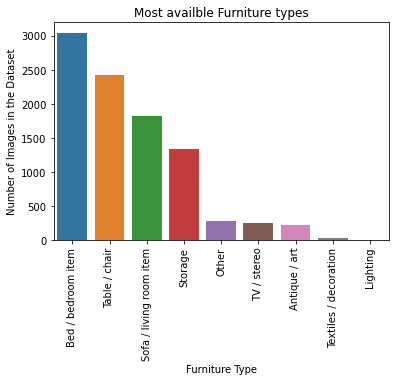

In [7]:
# Most available furniture types

top_fur_type = df[["Image_File", "Furniture_Type"]].groupby("Furniture_Type").agg(['count'])['Image_File']['count'].sort_values(ascending=False)[:10]
fig = sns.barplot( x = top_fur_type.index, y = top_fur_type.values)
fig.set_xticklabels(labels=top_fur_type.index , rotation=90)
fig.set_ylabel("Number of Images in the Dataset")
fig.set_xlabel("Furniture Type")
fig.set_title("Most availble Furniture types");

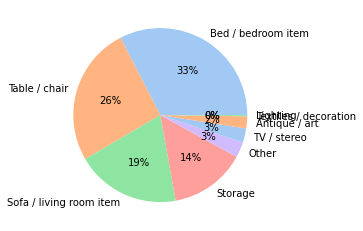

In [8]:
# Disrtribution of Classes among the Dataset
colors = sns.color_palette('pastel')[0:5]
plt.pie(top_fur_type, labels = top_fur_type.index, colors = colors, autopct='%.0f%%')
plt.show()

# Data Loader

## Pre process Data Labels

Labels are currently strings, we will need to convert them to int indexes (1, 2, 3, ...) so pytorch accepts them

In [9]:
classes = df['Furniture_Type'].unique().tolist()
classes.sort()
print("classes: ", classes)
print("number of classes: ", len(classes))

classes:  ['Antique / art', 'Bed / bedroom item', 'Lighting', 'Other', 'Sofa / living room item', 'Storage', 'TV / stereo', 'Table / chair', 'Textiles / decoration']
number of classes:  9


In [10]:
from sklearn import preprocessing
import torch

le = preprocessing.LabelEncoder()
df['Furniture_Type'] = le.fit_transform(df['Furniture_Type'])
# targets: array([0, 1, 2, 3])

# To transform back
# le.inverse_transform(df['Furniture_Type'])

In [11]:
df

,Label,Furniture_Type,Image_File
0,furniture set,3,1634011558853.jpg
1,bed room set,1,1634011559093.jpg
2,6by6 teak box bed with hybrids mattress,1,1634011559259.jpg
3,new spring mattress,1,1634011559590.jpg
4,exclusive 6 by teak box bed with spring mattress,1,1634011559751.jpg
...,...,...,...
9341,library cupboard,5,1634028757107.jpg
9342,piyestra cupboard,5,1634028757269.jpg
9343,dark 3d wardrobe,1,1634028757678.jpg
9344,3 door cupboard,1,1634028757990.jpg


## Split Data into testing and training

In [12]:
from sklearn.model_selection import train_test_split
furniture_train, furniture_test = train_test_split(df, test_size =0.25)
furniture_train.shape, furniture_test.shape

((7009, 3), (2337, 3))

## Custom DataSet

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models 
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

In [14]:
root_dir = IMG_PATH

Map-Style DataSet

In [15]:
class FurnitureDataset(Dataset):
    """Furniture dataset."""

    def __init__(self, data_frame, root_dir, transform=None):
        """
        Args:
            data_frame (pandadataframe): dataframe with data
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.furniture_csv = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.furniture_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir + self.furniture_csv.iloc[idx, 2]
        image = io.imread(img_name)
        label = self.furniture_csv.iloc[idx, 1]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
csv_file = "/content/drive/MyDrive/Colab Notebooks/CS573_MidTermProject/furniture_data_img.csv"
furniture_dataset = FurnitureDataset(df, root_dir)

Testing DataSet

0 (120, 160, 3) 3
<class 'numpy.ndarray'> <class 'numpy.int32'>
1 (120, 160, 3) 1
<class 'numpy.ndarray'> <class 'numpy.int32'>
2 (107, 142, 3) 1
<class 'numpy.ndarray'> <class 'numpy.int32'>
3 (107, 142, 3) 1
<class 'numpy.ndarray'> <class 'numpy.int32'>


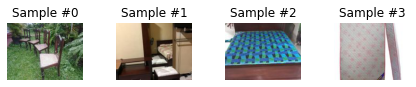

In [17]:
fig = plt.figure()

for i in range(len(furniture_dataset)):
    sample = furniture_dataset[i]

    print(i, sample['image'].shape, sample['label'])
    print(type(sample['image']), type(sample['label']))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(next(iter(sample.items()))[1])

    if i == 3:
        plt.show()
        break

## Data Regularization

In [18]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            #if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            #else:
            #    new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}

In [19]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.as_tensor(label)}

## Data Loader

Re-declaring Dataset

In [20]:
data_transform = transforms.Compose([Rescale(256), 
                                     ToTensor()])
train_furniture_dataset = FurnitureDataset(furniture_train, root_dir, data_transform)
test_furniture_dataset = FurnitureDataset(furniture_test, root_dir, data_transform)

0 torch.Size([3, 192, 256]) tensor(7, dtype=torch.int32)
<class 'torch.Tensor'> <class 'torch.Tensor'>
1 torch.Size([3, 192, 256]) tensor(1, dtype=torch.int32)
<class 'torch.Tensor'> <class 'torch.Tensor'>
2 torch.Size([3, 192, 256]) tensor(0, dtype=torch.int32)
<class 'torch.Tensor'> <class 'torch.Tensor'>
3 torch.Size([3, 192, 256]) tensor(7, dtype=torch.int32)
<class 'torch.Tensor'> <class 'torch.Tensor'>


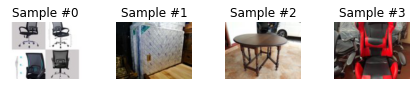

In [21]:
fig = plt.figure()

for i in range(len(train_furniture_dataset)):
    sample = train_furniture_dataset[i]
    print(i, sample['image'].shape, sample['label'])
    print(type(sample['image']), type(sample['label']))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    image_to_show = next(iter(sample.items()))[1]
    plt.imshow(image_to_show.permute(1,2,0))

    if i == 3:
        plt.show()
        break

In [22]:
batch_size = 500 # If running on colab make sure number is less than 10
# furniture_dataset = FurnitureDataset(csv_file, root_dir)
trainloader = torch.utils.data.DataLoader(train_furniture_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_furniture_dataset, batch_size=batch_size, shuffle=True)

Iterate though the DataLoader

tensor([5, 1, 1, 7, 1, 1, 6, 1, 1, 7, 1, 7, 1, 1, 4, 1, 4, 0, 7, 5, 4, 5, 4, 1,
        8, 7, 0, 1, 5, 4, 4, 7, 7, 5, 1, 5, 7, 5, 7, 7, 4, 4, 7, 4, 4, 7, 1, 4,
        1, 5, 5, 4, 7, 1, 4, 7, 4, 1, 6, 6, 1, 5, 7, 4, 7, 7, 7, 7, 1, 7, 7, 5,
        4, 1, 1, 7, 1, 1, 4, 4, 3, 5, 7, 4, 7, 7, 6, 7, 1, 1, 4, 5, 4, 5, 1, 1,
        4, 5, 4, 4, 1, 1, 5, 7, 4, 5, 4, 1, 4, 7, 5, 3, 4, 7, 7, 3, 1, 7, 1, 5,
        5, 7, 7, 7, 7, 4, 1, 1, 7, 4, 5, 1, 1, 1, 4, 5, 7, 7, 7, 4, 3, 7, 4, 7,
        1, 4, 4, 1, 4, 5, 4, 7, 7, 1, 1, 4, 6, 4, 5, 6, 3, 4, 1, 1, 7, 4, 1, 4,
        4, 4, 4, 1, 5, 1, 5, 5, 7, 5, 1, 5, 1, 4, 4, 1, 0, 7, 7, 5, 4, 5, 7, 1,
        7, 7, 7, 1, 1, 4, 6, 7, 7, 4, 1, 7, 1, 4, 1, 4, 1, 7, 1, 3, 7, 5, 1, 1,
        5, 7, 7, 1, 7, 7, 7, 6, 4, 4, 7, 4, 6, 7, 5, 4, 5, 5, 7, 1, 4, 1, 7, 1,
        7, 7, 1, 4, 1, 7, 4, 1, 7, 1, 7, 5, 5, 5, 5, 7, 7, 7, 1, 4, 5, 6, 1, 7,
        1, 1, 5, 7, 7, 4, 1, 1, 1, 7, 8, 7, 1, 5, 7, 1, 7, 4, 4, 1, 4, 5, 7, 4,
        7, 5, 1, 1, 7, 1, 7, 1, 0, 4, 7,

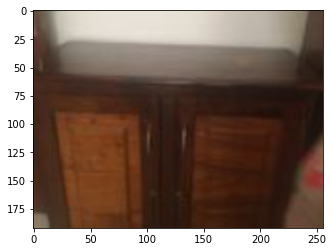

Label: 5


In [23]:
first_data = next(iter(testloader))
train_image = first_data["image"]
train_labels = first_data["label"]
print(train_labels)
print(f"Feature batch shape: {train_image.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_image[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {label}")

# Summary of Variables

trainloader - > DataLoader with training images
testloader - > Data Loader with Test images
IMG_PATH/root_dir - > Directory with images


# Image Classifier Model

## Define a CNN model

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(device)
print(model)

cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

## Define a Loss Function and an optimizer

In [26]:
from torch import optim
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train the network

In [27]:
 torch.cuda.empty_cache()

In [28]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for data_out in trainloader:
        inputs = data_out["image"]
        labels = data_out["label"]
        labels = labels.type(torch.LongTensor)
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs.float())
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for data_out2 in testloader:
                    inputs = data_out2["image"]
                    labels = data_out2["label"]
                    labels = labels.type(torch.LongTensor)
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs.float())
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'furnituremodel.pth')

Epoch 1/10.. Train loss: 3.514.. Test loss: 2.053.. Test accuracy: 0.391
Epoch 2/10.. Train loss: 1.541.. Test loss: 1.291.. Test accuracy: 0.574
Epoch 2/10.. Train loss: 1.224.. Test loss: 1.154.. Test accuracy: 0.572
Epoch 3/10.. Train loss: 1.060.. Test loss: 1.030.. Test accuracy: 0.658
Epoch 4/10.. Train loss: 0.996.. Test loss: 1.014.. Test accuracy: 0.662
Epoch 4/10.. Train loss: 0.971.. Test loss: 0.953.. Test accuracy: 0.681
Epoch 5/10.. Train loss: 0.907.. Test loss: 0.948.. Test accuracy: 0.684
Epoch 6/10.. Train loss: 0.882.. Test loss: 1.001.. Test accuracy: 0.657
Epoch 6/10.. Train loss: 0.897.. Test loss: 0.889.. Test accuracy: 0.695
Epoch 7/10.. Train loss: 0.846.. Test loss: 0.896.. Test accuracy: 0.687
Epoch 8/10.. Train loss: 0.783.. Test loss: 0.902.. Test accuracy: 0.688
Epoch 8/10.. Train loss: 0.836.. Test loss: 0.871.. Test accuracy: 0.713
Epoch 9/10.. Train loss: 0.791.. Test loss: 0.909.. Test accuracy: 0.705
Epoch 10/10.. Train loss: 0.793.. Test loss: 0.952.

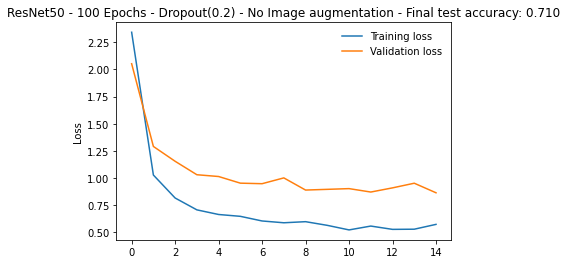

In [32]:
plt.title("ResNet50 - 100 Epochs - Dropout(0.2) - No Image augmentation - Final test accuracy: 0.710")
plt.ylabel("Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

['Antique / art', 'Bed / bedroom item', 'Lighting', 'Other', 'Sofa / living room item', 'Storage', 'TV / stereo', 'Table / chair', 'Textiles / decoration']


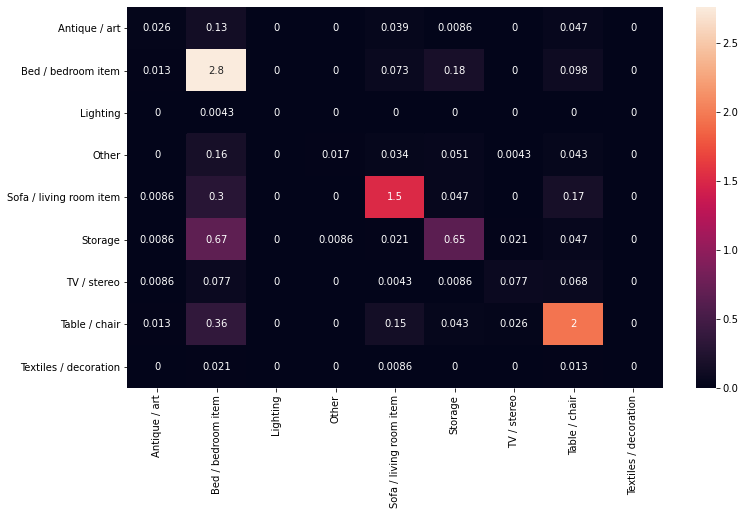

In [52]:
y_pred = []
y_true = []
# iterate over test data
for data_out in testloader:
        inputs = data_out["image"]
        labels = data_out["label"]
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs.float())
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        
        y_pred.extend(top_class.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
classes = ['Antique / art', 'Bed / bedroom item', 'Lighting', 'Other', 'Sofa / living room item', 'Storage', 'TV / stereo', 'Table / chair', 'Textiles / decoration']
print(classes)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
